In [2]:
# run "pip install grad-cam"
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152
import numpy as np
# import matplotlib
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

/u/k/e/kesong/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# use the last gpu
device = 'cuda:'+str(torch.cuda.device_count()-1) if torch.cuda.is_available() else 'cpu'

In [7]:
device

'cuda:7'

In [8]:
model1 = resnet18(pretrained=True).to(device)
model2 = resnet34(pretrained=True).to(device)
model3 = resnet50(pretrained=True).to(device)
model4 = resnet101(pretrained=True).to(device)
model5 = resnet152(pretrained=True).to(device)

def get_gradcam_saliency_maps(x, y, model):
  with GradCAM(model=model, target_layers=[model.layer4[-1]], use_cuda=torch.cuda.is_available()) as cam:
      targets = [ClassifierOutputTarget(y)]

      # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
      grayscale_cam = cam(input_tensor=x, targets=targets)

      # TODO: Do we want to use eigen_smooth=True in the above function to remove some of the noise??

  return grayscale_cam

/u/k/e/kesong/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/u/k/e/kesong/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /u/k/e/kesong/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:11<00:00, 4.16MB/s]
/u/k/e/kesong/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are depr

In [9]:
def compare_saliency_maps(sm1, sm2):
    return np.abs(sm1 - sm2).sum()

In [16]:
# train = datasets.CIFAR10(root = '/home/jupyter/cs762/data', train=True,  transform=transforms.Compose([transforms.ToTensor(), transforms.Resize([224, 224])]), download=True)
train = datasets.CIFAR10(root='~/cs762/data', train=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Resize([224, 224])]), download=True)
data_loader = torch.utils.data.DataLoader(train, batch_size=1,
                                                 shuffle=True, num_workers=1)

Files already downloaded and verified


In [20]:
import os
imagenetfolder = '/nobackup/ImageNet'

traindir = os.path.join(imagenetfolder, 'train')
valdir = os.path.join(imagenetfolder, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(
    traindir,
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

val_dataset = datasets.ImageFolder(
    valdir,
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))

data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
                                                 shuffle=True, num_workers=16)

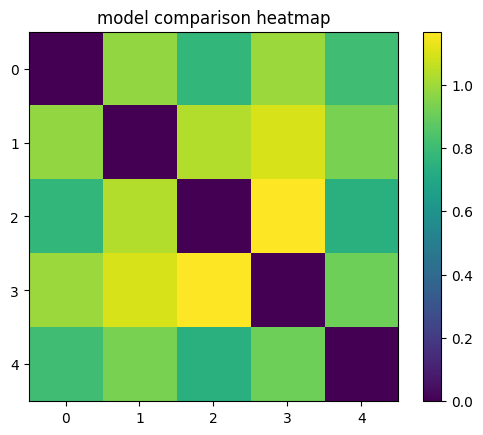

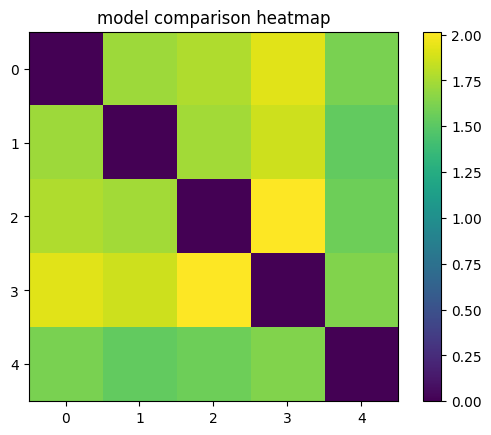

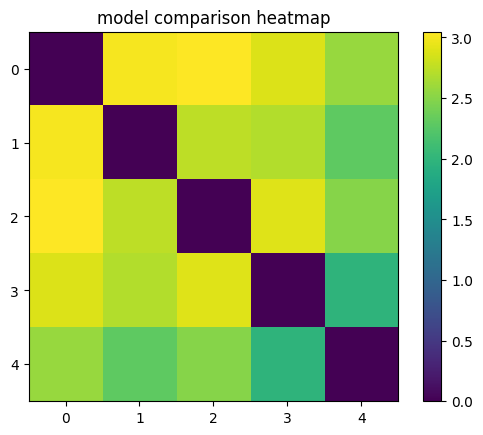

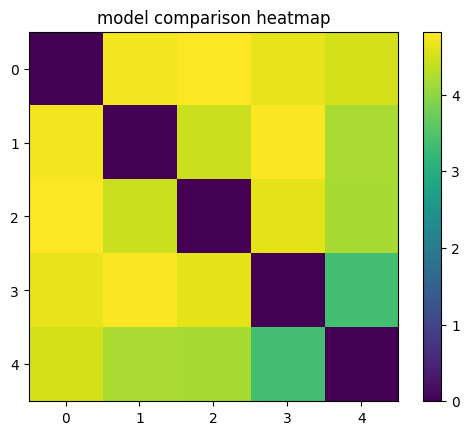

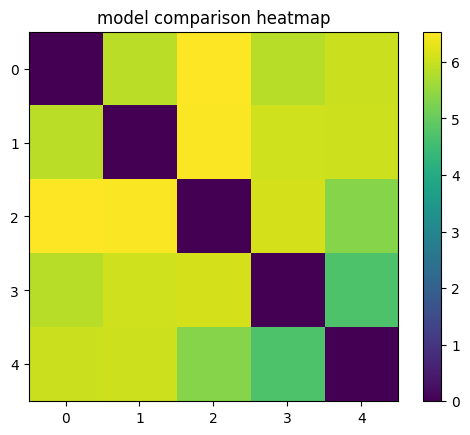

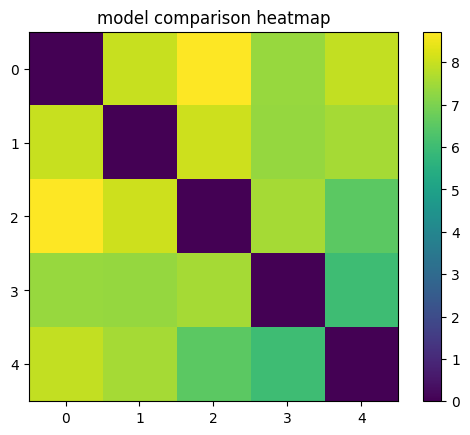

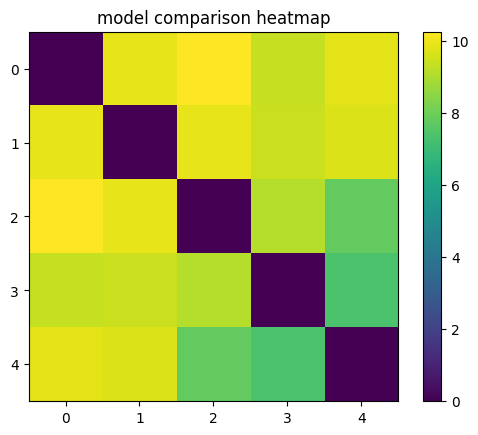

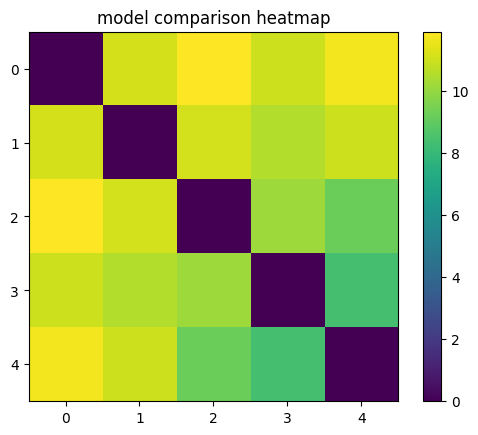

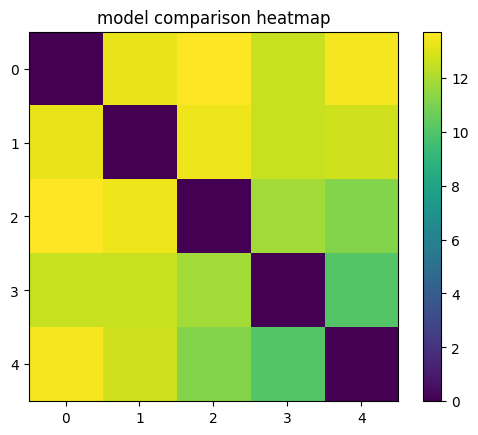

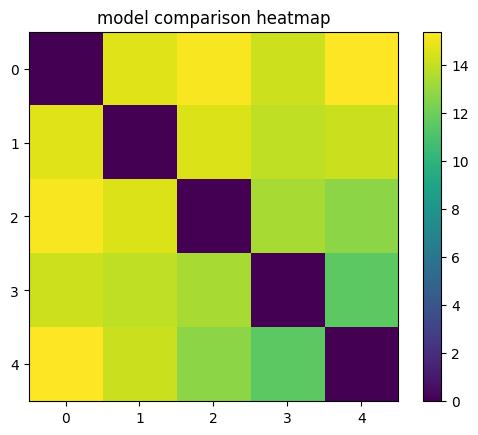

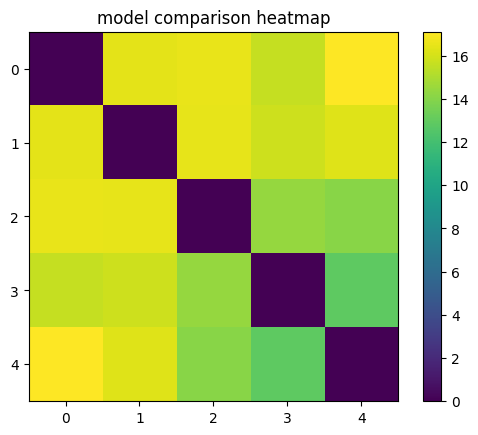

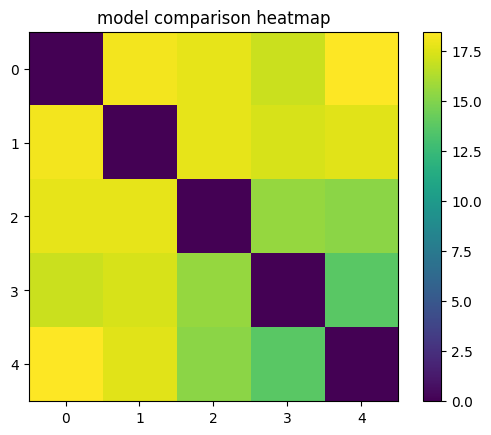

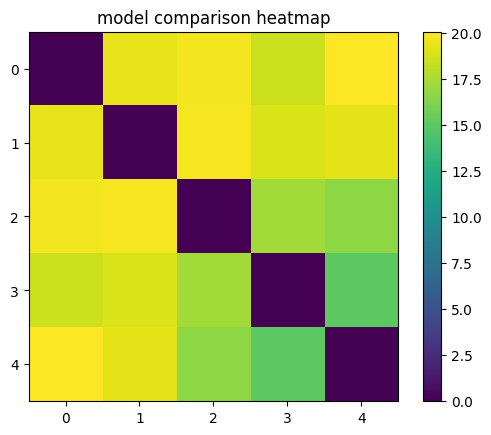

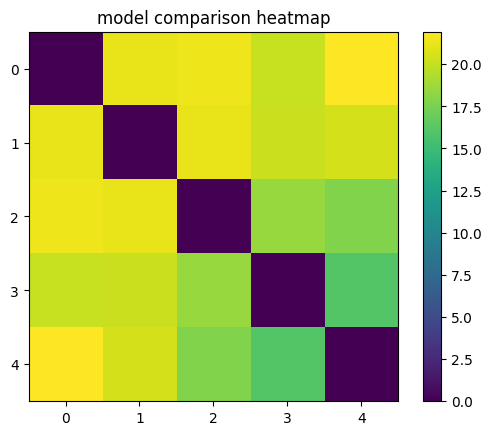

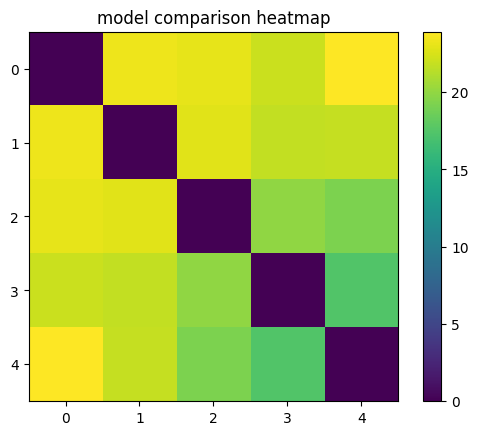

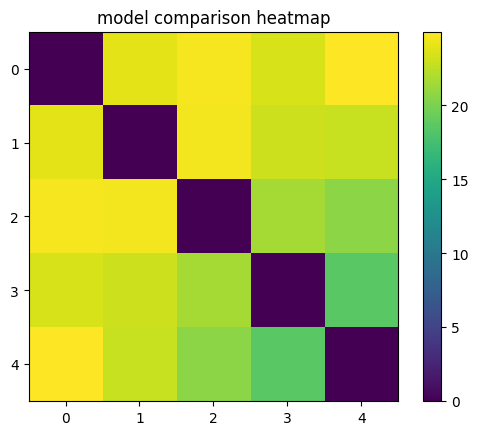

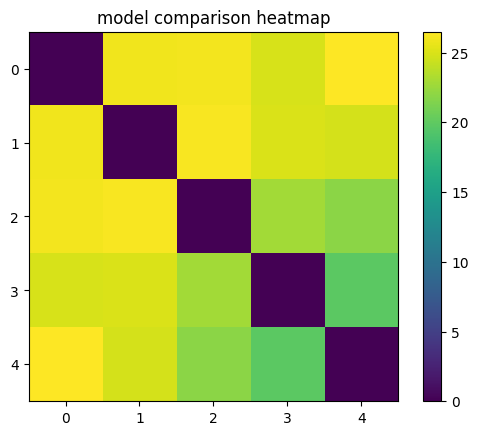

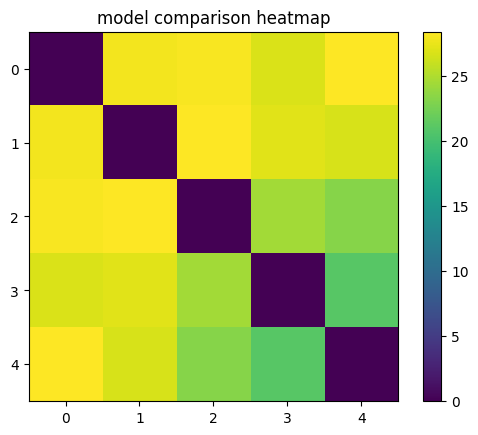

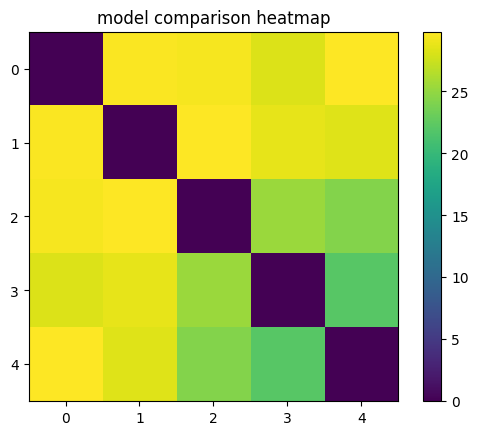

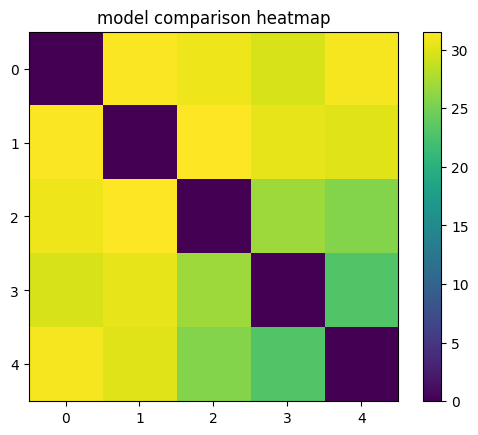

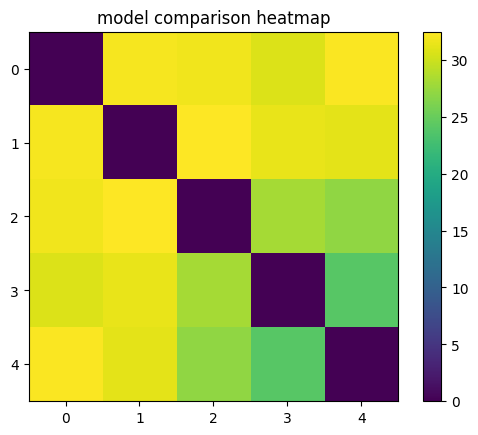

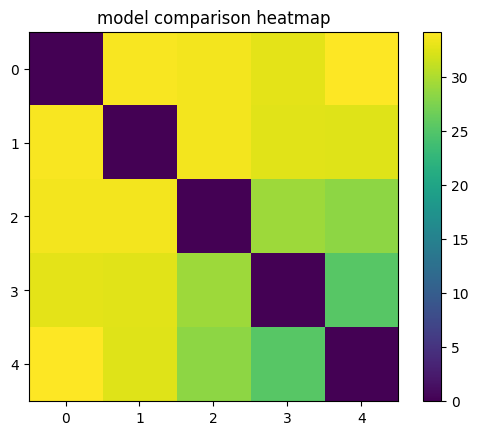

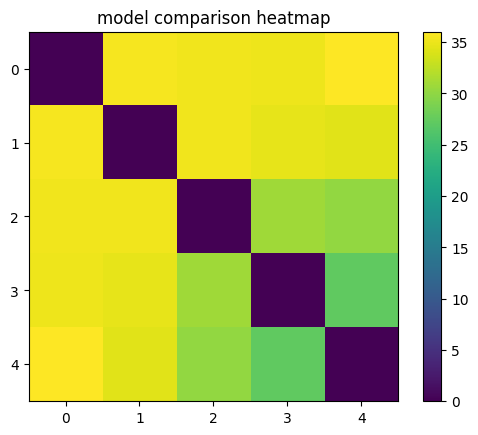

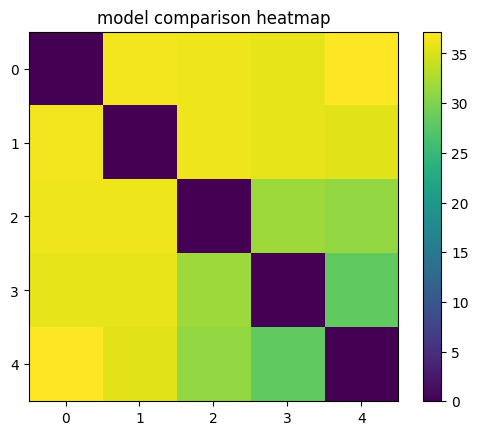

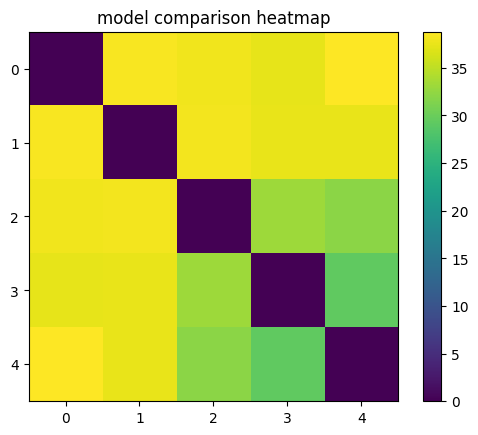

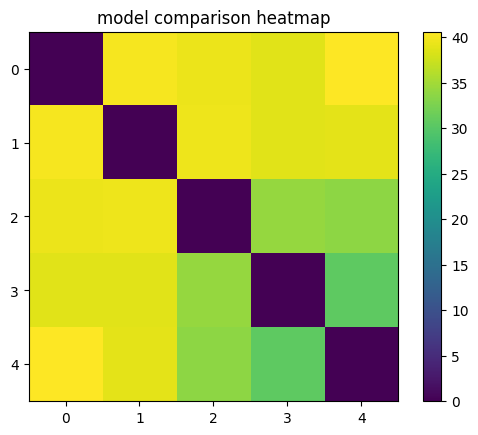

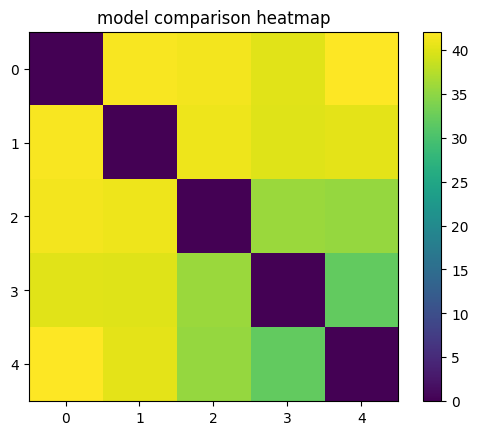

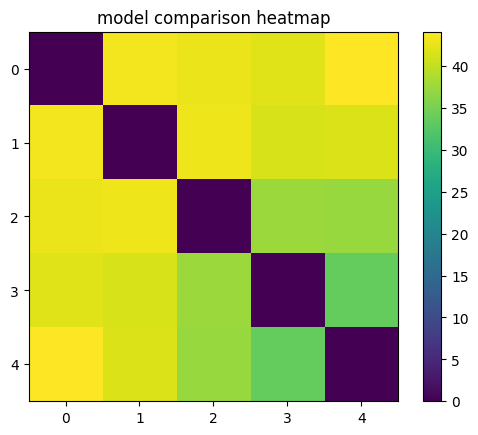

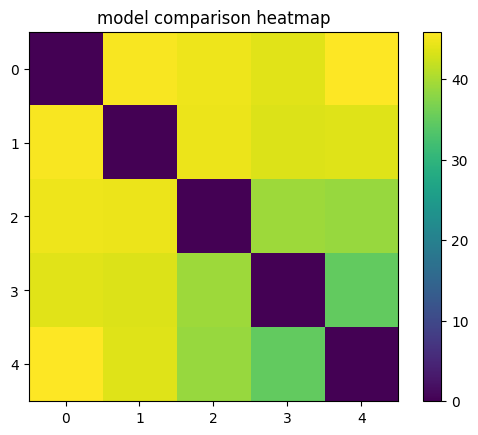

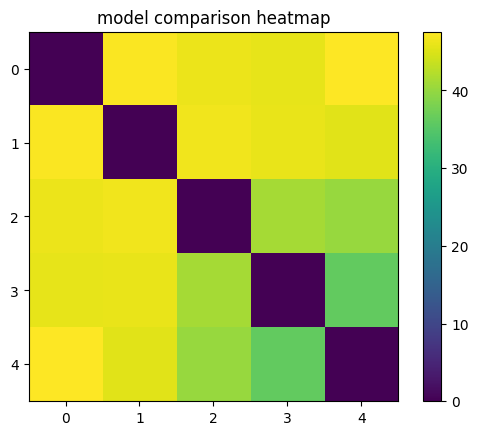

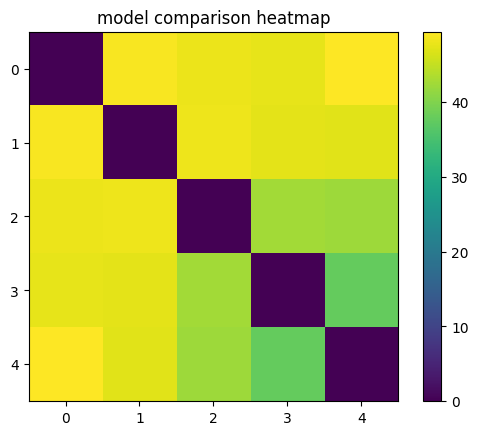

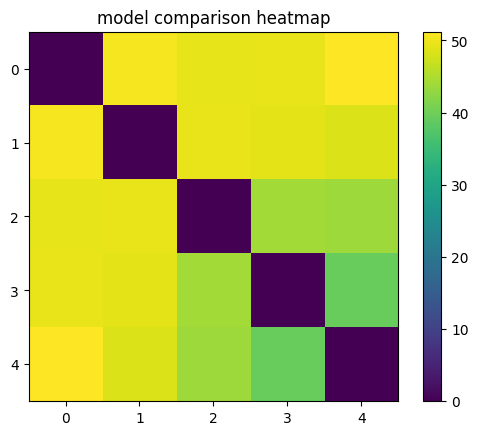

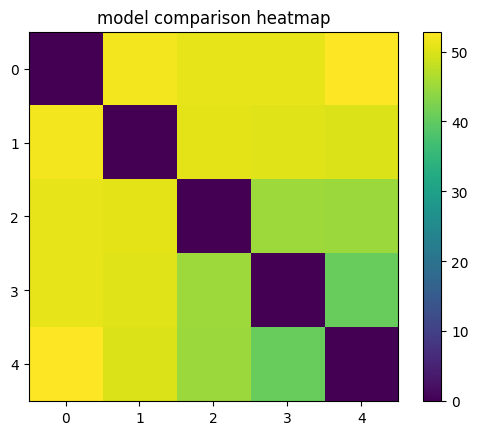

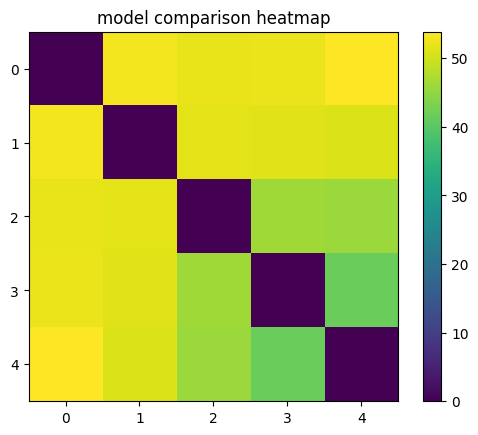

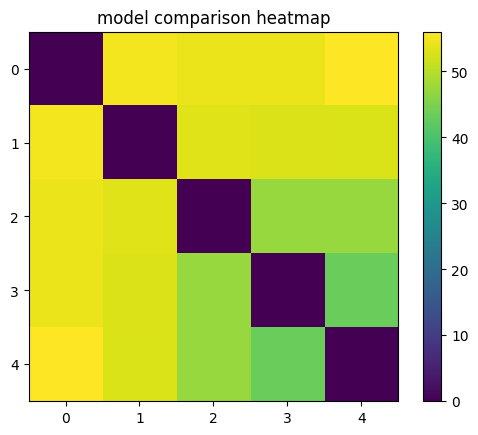

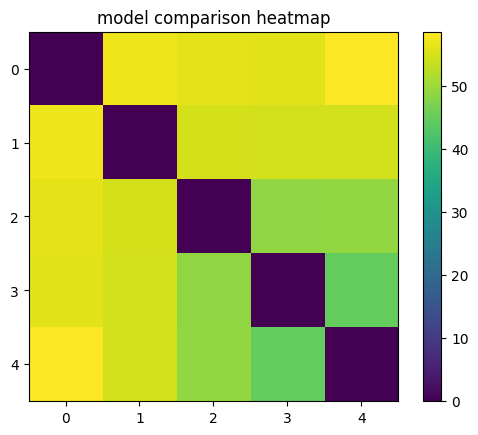

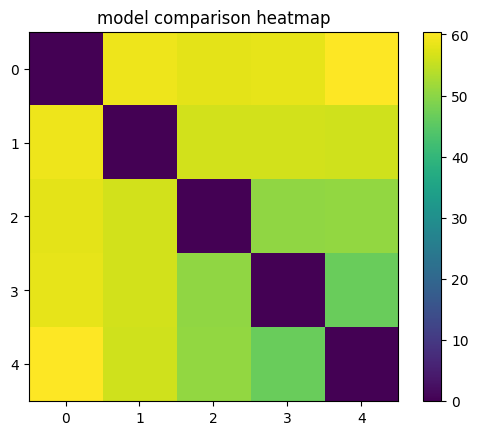

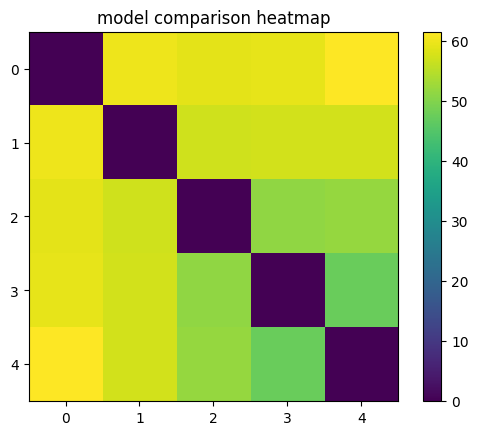

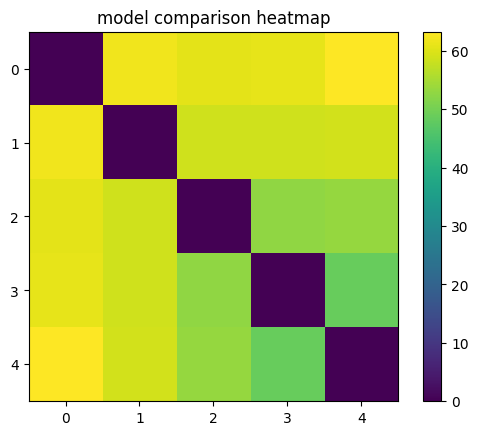

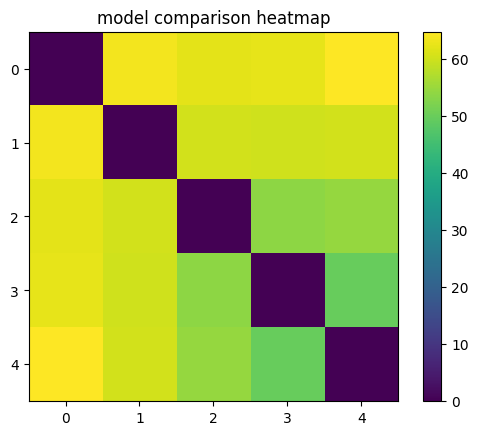

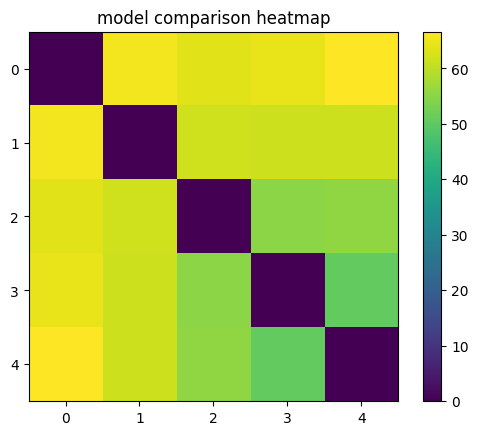

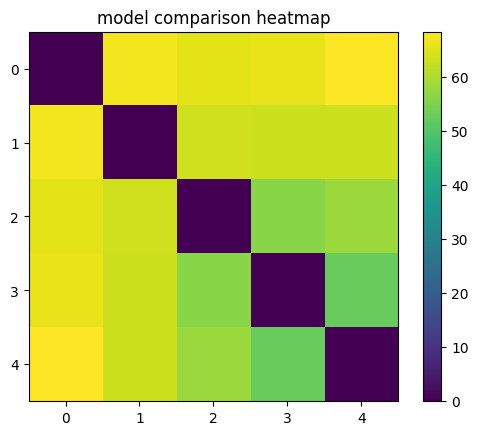

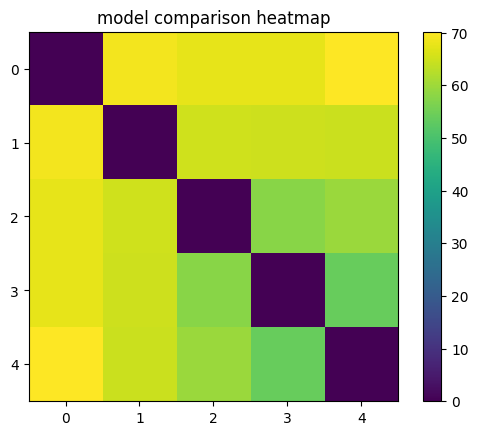

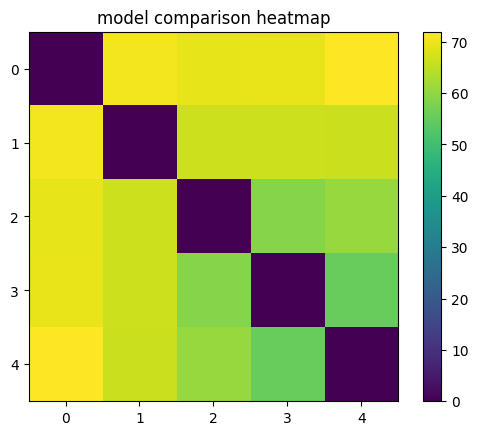

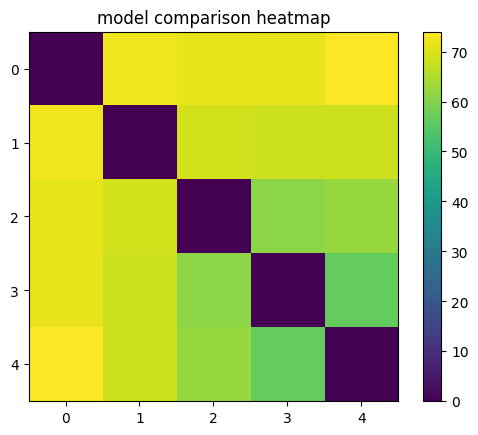

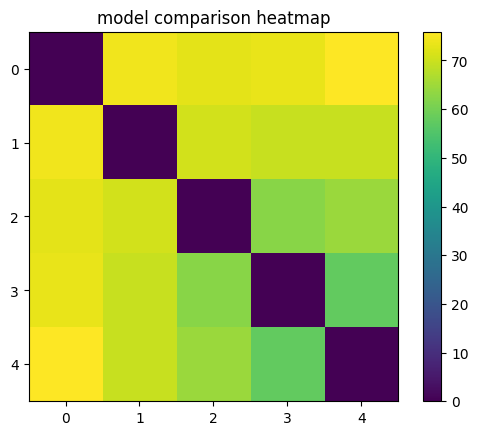

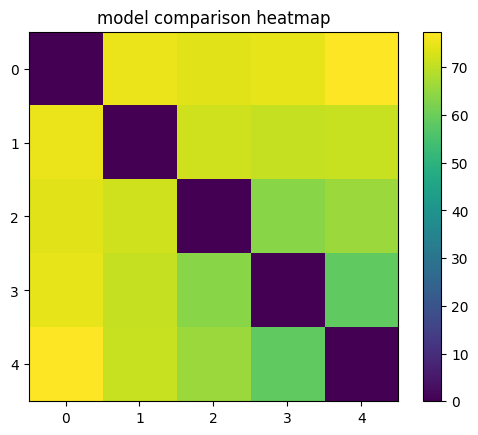

KeyboardInterrupt: 

In [21]:
import matplotlib
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


models_list = [model1, model2, model3, model4, model5]

num_classes = 10
model_heatmap = np.array([[0 for i in range(len(models_list))] for j in range(len(models_list))], dtype=float)

# about 20s per batch
for batch in data_loader:  # Get batch
  images, labels = batch  # Unpack the batch into images and labels
  # labels = labels - labels
  # images, labels = images.to(device), labels.to(device)

  model_predictions_dict = {i:[] for i in range(len(models_list))}

  # look at all labels
  for label in range(num_classes):
    labels = torch.tensor([label])
    images, labels = images.to(device), labels.to(device)

    for model_index in range(len(models_list)):
      model_predictions_dict[model_index].append(get_gradcam_saliency_maps(images, labels, models_list[model_index]))
    
  for model_index1 in range(len(models_list)):
    for model_index2 in range(len(models_list)):
      sm1 = np.array(model_predictions_dict[model_index1])
      sm2 = np.array(model_predictions_dict[model_index2])
      model_heatmap[model_index1, model_index2] += compare_saliency_maps(sm1, sm2)/len(data_loader.dataset)

    
      # for model_index2 in range(len(models_list)):
      #   sm1 = get_gradcam_saliency_maps(images, labels, models_list[model_index1])
      #   sm2 = get_gradcam_saliency_maps(images, labels, models_list[model_index2])
      #   model_heatmap[model_index1, model_index2] += compare_saliency_maps(sm1, sm2)/len(data_loader.dataset)

        # plt.imshow(images[0].detach().cpu().permute([1, 2, 0]))
        # plt.show()
        # plt.imshow(sm1[0], cmap="gray")
        # plt.show()

  plt.imshow(model_heatmap)
  plt.title("model comparison heatmap")
  plt.colorbar()
  plt.show()

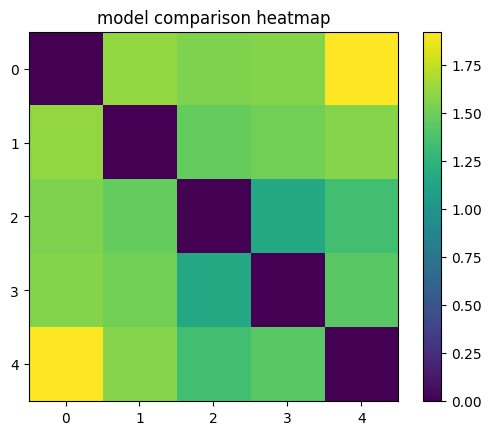

In [12]:
plt.imshow(model_heatmap)
plt.title("model comparison heatmap")
plt.colorbar()
plt.show()